In [1]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models
from ..models import VGG16
from ..utils import *
from tqdm import trange

log_to_stdout()

In [2]:
batch_size = 1
device = get_device()
loss_fn = nn.MSELoss()

2022-12-06 21:13:08,734 INFO: using mps device


In [3]:
training_data = datasets.ImageNet(
    root=get_imgnet_root(),
    split="train",
    transform=Compose(
        [models.ResNet50_Weights.DEFAULT.transforms(), inv_imgnet_scaling()]
    ),
)
training_classes = torch.tensor(training_data.targets)
training_ind = (training_classes == 1) | (training_classes == 2)
training_data = Subset(training_data, torch.nonzero(training_ind))

test_data = datasets.ImageNet(
    root=get_imgnet_root(),
    split="val",
    transform=Compose(
        [models.ResNet50_Weights.DEFAULT.transforms(), inv_imgnet_scaling()]
    ),
)
test_classes = torch.tensor(test_data.targets)
test_ind = (test_classes == 1) | (test_classes == 2)
test_data = Subset(test_data, torch.nonzero(test_ind))

In [4]:
train_dataloader = DataLoader(training_data, batch_size, True)
test_dataloader = DataLoader(test_data, batch_size, True)

In [5]:
model = VGG16().to(device)
model.load_state_dict(
    torch.load("finals/ImgNetAEC.pth", map_location=device), strict=True
)
model.eval()

VGG16(
  (down1): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (conv2): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (conv2): conv2DBatchNormRelu(
      

In [6]:
for X, labels in test_dataloader:
    break
X = X.to(device)

In [7]:
with torch.no_grad():
    Y = model.encoder(X)

In [8]:
Y.size(), Y.numel()

(torch.Size([1, 512, 7, 7]), 25088)

In [9]:
Y.requires_grad_(True)
Z = model.decoder(Y)
n_pixels = Z.numel()
n_latents = 10  # Y.numel()
G = torch.empty(n_pixels, n_latents, device=device)
for i in trange(n_pixels):
    model.zero_grad()
    if i > 0:
        Y.grad *= 0.0
    torch.flatten(Z)[i].backward(retain_graph=(i < n_pixels - 1))
    G[i] = torch.flatten(Y.grad)[:n_latents]

100%|█████████████████████████████████| 150528/150528 [1:01:37<00:00, 40.71it/s]


In [10]:
H = G.T.resize(n_latents, 3, 224, 224)

/Users/lukas/miniconda3/envs/torch-env/lib/python3.10/site-packages/torch/_tensor.py:755: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [17]:
assert torch.all(torch.flatten(Y.grad)[:n_latents] == H[:, 2, 223, 223]).item()
X = X.cpu().detach_()
Z = Z.cpu().detach_()

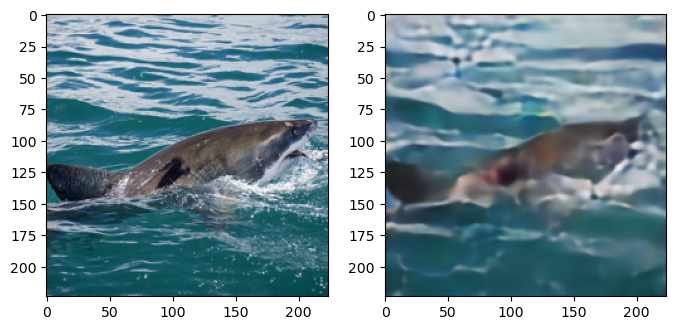

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(torch.permute(X.squeeze(), (1, 2, 0)))
axs[1].imshow(torch.permute(Z.squeeze(), (1, 2, 0)))
plt.show()

In [19]:
maxs = H.max(-1).values.max(-1).values.max(-1).values
mins = H.min(-1).values.min(-1).values.min(-1).values

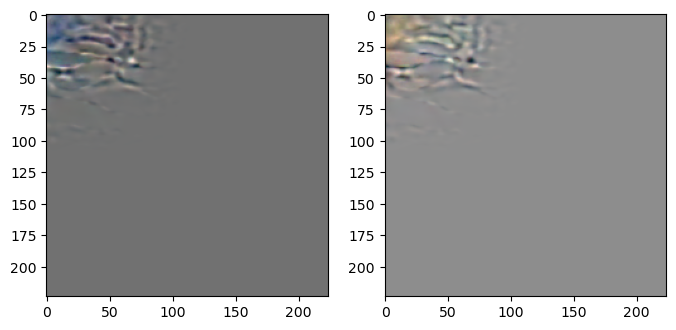

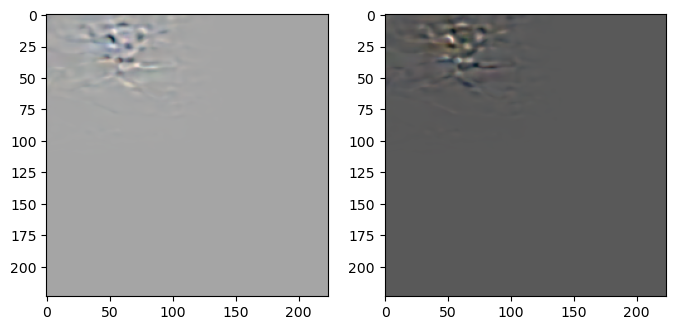

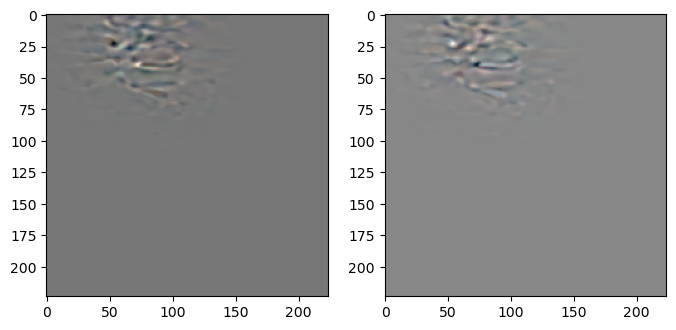

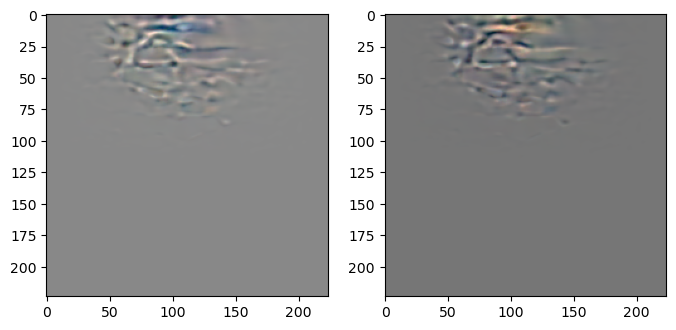

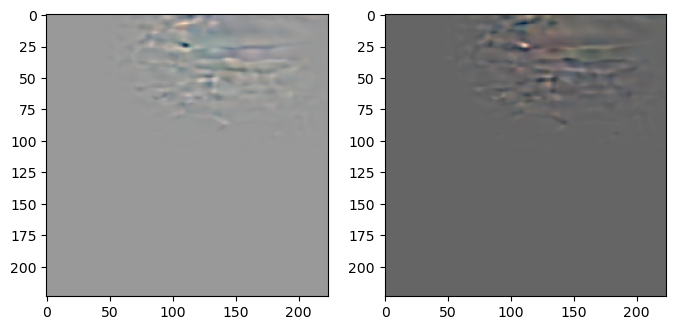

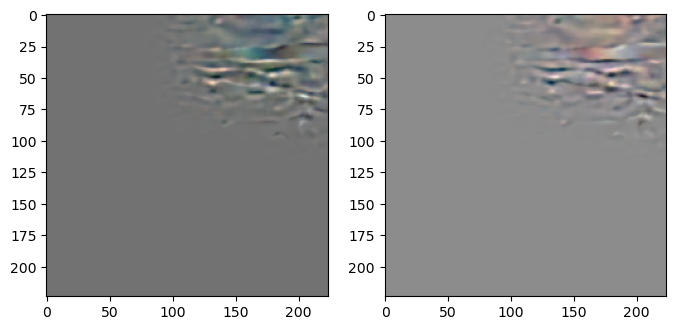

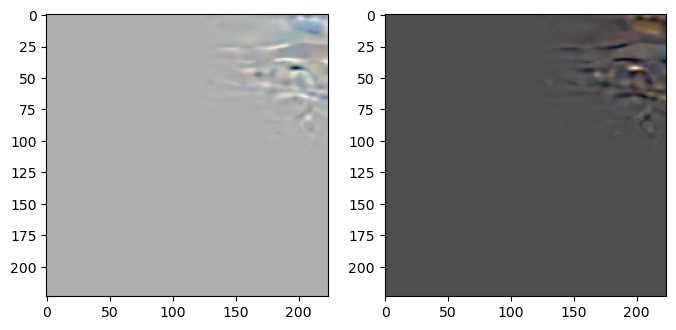

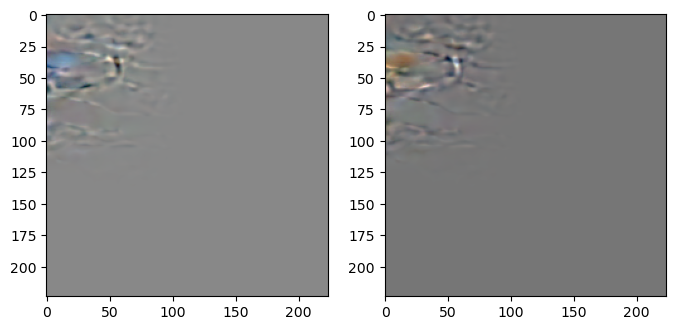

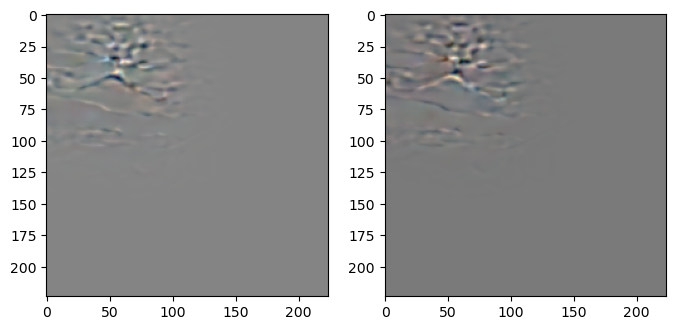

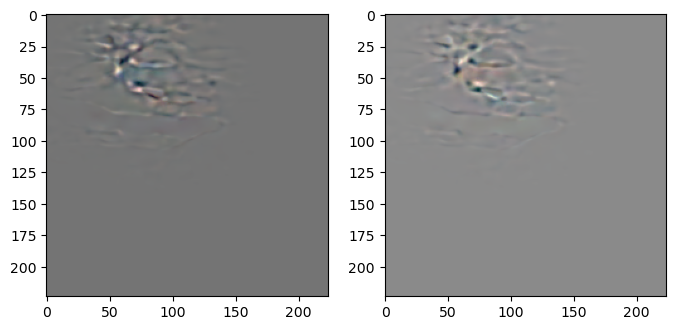

In [21]:
for i in range(n_latents):
    with torch.no_grad():
        P = torch.permute((H[i] - mins[i]) / (maxs[i] - mins[i]), (1, 2, 0)).cpu()
        P_ = 1.0 + -1.0 * P
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(P)
    axs[1].imshow(P_)
    plt.show()

/Users/lukas/miniconda3/envs/torch-env/lib/python3.10/site-packages/torch/_tensor.py:755: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


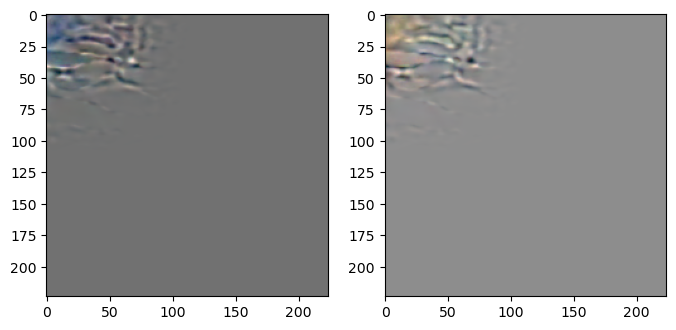

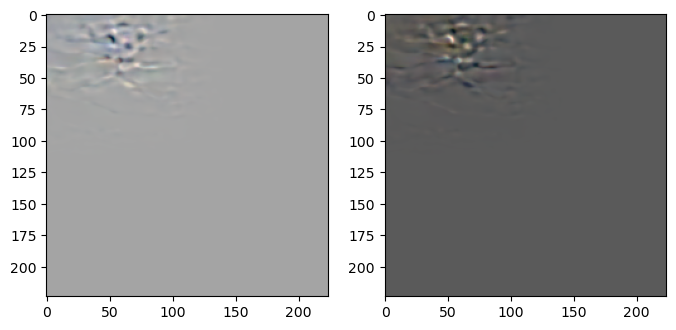

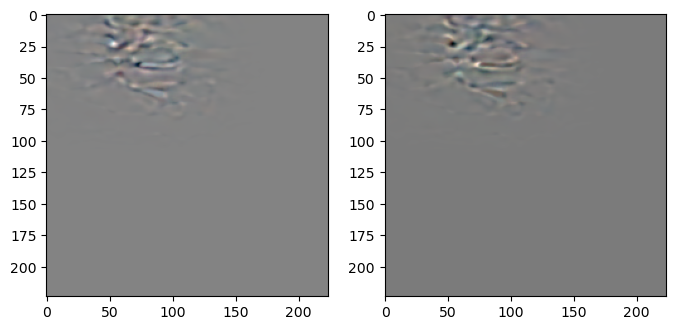

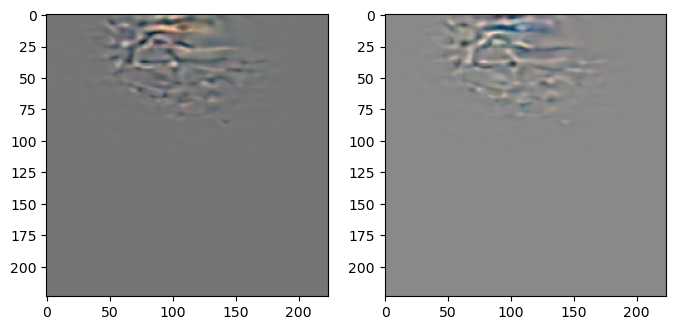

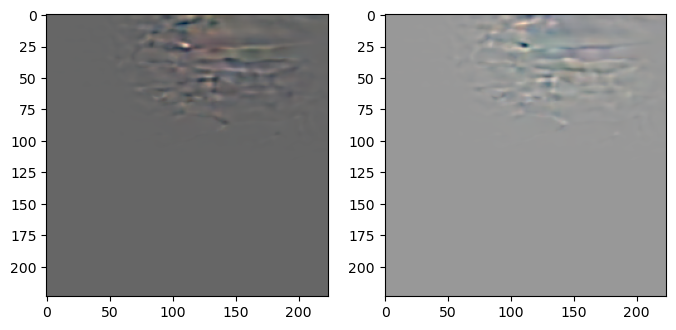

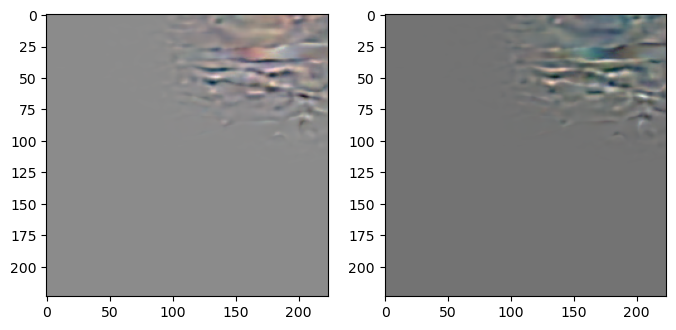

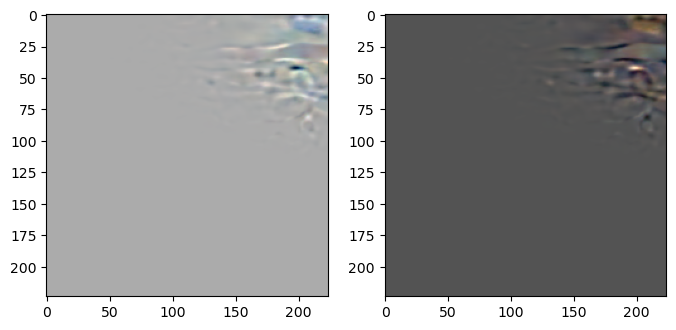

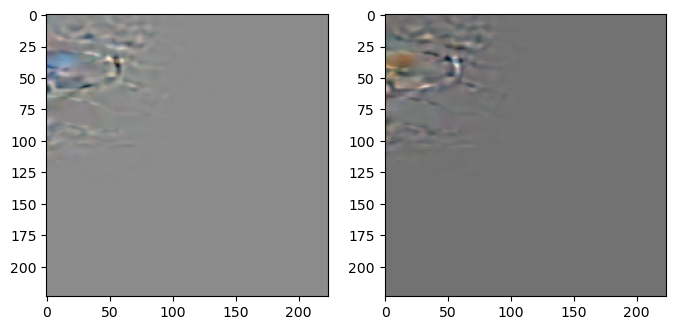

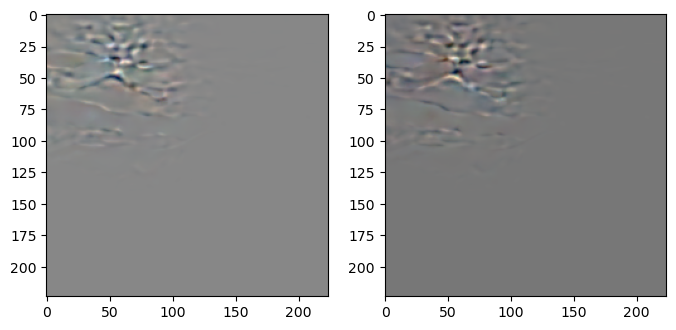

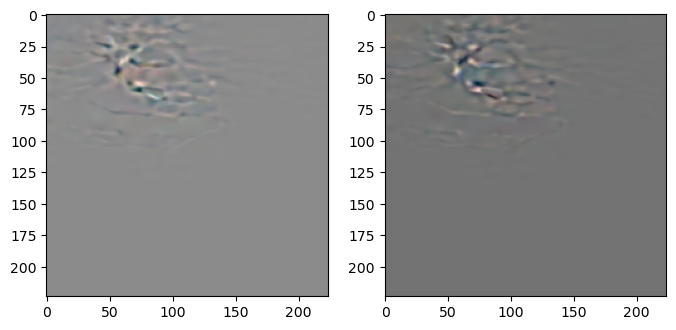

In [23]:
with torch.no_grad():
    Q, R = torch.linalg.qr(G.cpu())
    H = Q.T.resize(n_latents, 3, 224, 224)

maxs = H.max(-1).values.max(-1).values.max(-1).values
mins = H.min(-1).values.min(-1).values.min(-1).values

for i in range(n_latents):
    with torch.no_grad():
        P = torch.permute((H[i] - mins[i]) / (maxs[i] - mins[i]), (1, 2, 0))
        P_ = 1.0 + -1.0 * P
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(P)
    axs[1].imshow(P_)
    plt.show()

In [24]:
torch.histogram(torch.diag(R) ** 2 / (R**2).sum(0), bins=10)

torch.return_types.histogram(
hist=tensor([2., 1., 1., 0., 1., 0., 0., 0., 1., 4.]),
bin_edges=tensor([0.9473, 0.9526, 0.9578, 0.9631, 0.9684, 0.9737, 0.9789, 0.9842, 0.9895,
        0.9947, 1.0000]))